Libraries Used

In [2]:
## Import Libraries
!pip install plotly
!pip install jupyter_to_medium
import pandas as pd 
from bs4 import BeautifulSoup
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import chart_studio.plotly as py
import plotly.offline as po
import plotly.graph_objs as pg
import matplotlib.pyplot as plt
%matplotlib inline

Web Scraping

In [3]:
## Empty dataframe. The dataframe for each year will be appended on this empty dataframe
df = pd.DataFrame(columns = ['Name', 'Location', 'Date of Death', 'Cause of Death'])

## Creating a loop for the url of each year from 2010 to 20202
urls = []
years = range(2012, 2023)
for i in years:
    url = "https://www.odmp.org/search/year?year="
    new_url = url + str(i)
    urls.append(new_url)

## Scrapping the data on the url
for i in range(0, 11):
    url = urls[i]
    result = requests.get(url)
    doc = BeautifulSoup(result.text, "html.parser")
    doc_main = doc.find("main", id="main")
    p_data = doc_main.find_all("p")

## Getting the string on the name tag and putting it on a list
    data = []
    for i in p_data:
        #i.text
        data.append(i.string)
        
## The data contains both died police and k9. The data related to K9 are located at the end part of the list
## Determine the index where k9 data starts
    def index_containing_substring(data, substring):
        for i, s in enumerate(data):
            if substring in s:
                return i
        return -1
    K9_index_start = index_containing_substring(data, "K9")
    
    
## Removing K9 data
    final_data = data[0:K9_index_start]

## Dividing the list per police information
    final_data = [final_data[x:x+4] for x in range(0, len(final_data),4)]

## Concate year dataframe to the main dataframe
    df_data = pd.DataFrame(final_data, columns =['Name', 'Location', "Date of Death", "Cause of Death"])
    df = pd.concat([df, df_data], axis=0)
    

##The scrapped data. The data still needs cleaning
df.head()


,Name,Location,Date of Death,Cause of Death
0,Sergeant Abimael Castro-Berrocales,"Puerto Rico Police Department, PR","EOW: Sunday, January 1, 2012",Cause: Gunfire
1,Park Ranger Margaret A. Anderson,United States Department of the Interior - Nat...,"EOW: Sunday, January 1, 2012",Cause: Gunfire
2,Director of Field Operations Julio Daniel La Rosa,United States Department of the Treasury - Int...,"EOW: Tuesday, January 3, 2012",Cause: Heart attack
3,Agent Jared Daniel Francom,"Ogden Police Department, UT","EOW: Thursday, January 5, 2012",Cause: Gunfire
4,Master Patrolman Mitchell DeWayne Weeks,"McAlester Police Department, OK","EOW: Friday, January 6, 2012",Cause: Heart attack


Data Cleaning

In [4]:
## Using Regex to retrieve only the State in the Location column
search = []    
for values in df['Location']:
    search.append(re.search(r'[A-Z]{2}', values).group())
df['Location'] = search

##Removing the Cause: in the Cause of Death column
df[['Cause of Death','Cause of Death']] = df['Cause of Death'].str.split(':',expand=True)

##Removing the EOW: in the Date of Death column
df[['Date of Death','Date of Death']] = df['Date of Death'].str.split(':',expand=True)

##Separating Month, Day, and Year on the Date of Death column
df[["Day", "Month", "Year"]] = df["Date of Death"].str.split(",", expand = True)
df[["Month", "Month", "Month2"]] = df["Month"].str.split(" ", expand = True)
df["Date of Death"] = df["Month"] + " " + df["Month2"] + "," + df["Year"]
df = df[["Name", "Location", "Cause of Death", "Date of Death", "Day", "Month", "Year"]]
df = df.rename(columns = {"Day": "Day of Death", "Month": "Month of Death", "Year": "Year of Death","Location": "State of Death"})

##The cleaned data
df.head()

,Name,State of Death,Cause of Death,Date of Death,Day of Death,Month of Death,Year of Death
0,Sergeant Abimael Castro-Berrocales,PR,Gunfire,"January 1, 2012",Sunday,January,2012
1,Park Ranger Margaret A. Anderson,US,Gunfire,"January 1, 2012",Sunday,January,2012
2,Director of Field Operations Julio Daniel La Rosa,US,Heart attack,"January 3, 2012",Tuesday,January,2012
3,Agent Jared Daniel Francom,UT,Gunfire,"January 5, 2012",Thursday,January,2012
4,Master Patrolman Mitchell DeWayne Weeks,OK,Heart attack,"January 6, 2012",Friday,January,2012


In [5]:
## Checking if there are any missing values
df.isnull().sum()

Name              0
State of Death    0
Cause of Death    0
Date of Death     0
Day of Death      0
Month of Death    0
Year of Death     0
dtype: int64

In [6]:
## Checking the count and unique values on each of the columns
df.describe()  #State of Death column has 58 States which is seems incorrect

,Name,State of Death,Cause of Death,Date of Death,Day of Death,Month of Death,Year of Death
count,2348,2348,2348,2348,2348,2348,2348
unique,2348,57,27,1485,7,12,11
top,Sergeant Abimael Castro-Berrocales,TX,COVID19,"August 25, 2021",Thursday,September,2021
freq,1,301,793,9,380,252,638


In [7]:
## Inspecting the State of Death column
df["State of Death"].unique()  ## US, PR, AS, TR, VI, GU, UM are not a state and must be deleted

array(['PR', 'US', 'UT', 'OK', 'AZ', 'CT', 'NV', 'LA', 'AR', 'HI', 'KY',
       'OH', 'GA', 'MD', 'SC', 'AL', 'NY', 'FL', 'WV', 'WA', 'IN', 'TX',
       'VA', 'MA', 'NC', 'CA', 'NH', 'RI', 'PA', 'MS', 'TN', 'CO', 'IA',
       'NJ', 'IL', 'WI', 'NM', 'MI', 'VI', 'MN', 'MO', 'KS', 'TR', 'AK',
       'OR', 'NE', 'MT', 'DC', 'GU', 'ID', 'VT', 'ND', 'DE', 'WY', 'ME',
       'SD', 'UM'], dtype=object)

In [8]:
## Deleting those that are identified not a state
df = df[~df['State of Death'].isin(['US','PR', 'AS', 'TR', 'VI', 'GU', 'UM']) ]
df.head()

,Name,State of Death,Cause of Death,Date of Death,Day of Death,Month of Death,Year of Death
3,Agent Jared Daniel Francom,UT,Gunfire,"January 5, 2012",Thursday,January,2012
4,Master Patrolman Mitchell DeWayne Weeks,OK,Heart attack,"January 6, 2012",Friday,January,2012
5,Deputy Sheriff William Hauley Coleman,AZ,Gunfire,"January 8, 2012",Sunday,January,2012
6,Detective Andrew F. Faggio,CT,Automobile crash,"January 11, 2012",Wednesday,January,2012
7,Deputy Sheriff Denny Van Lawrence,NV,Gunfire,"January 17, 2012",Tuesday,January,2012


Data Analysis

Text(0, 0.5, 'Cumulative Percentage')

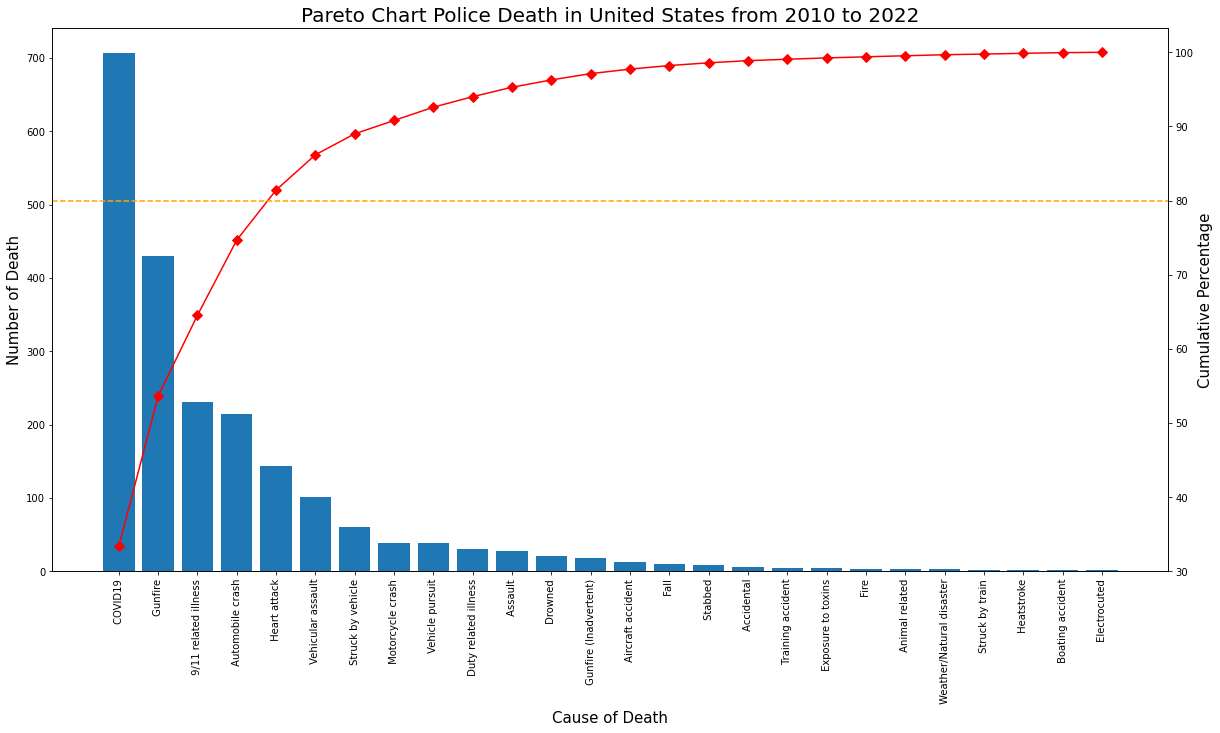

In [9]:
## Identifying the Top Causes of Deaths Using Pareto Analysis
## Creating Cumulative Percentage Table
df_cause_of_death = df.groupby(['Cause of Death']).count().reset_index()
df_cause_of_death = df_cause_of_death[["Cause of Death", "Name"]].rename(columns={"Name":"Number of Deaths"}).sort_values(by="Number of Deaths", ascending=False)
df_cause_of_death['Cum_Sum'] = df_cause_of_death["Number of Deaths"].cumsum()
df_cause_of_death['Cum_Percentage'] = round(100*df_cause_of_death.Cum_Sum/df_cause_of_death["Number of Deaths"].sum(),2)
df_cause_of_death.reset_index()

## Plot Count
ig, ax = plt.subplots(figsize=(20,10))
ax.bar(df_cause_of_death["Cause of Death"], df_cause_of_death["Number of Deaths"])
ax.set_title("Pareto Chart Police Death in United States from 2010 to 2022", size=20)
ax.set_xlabel("Cause of Death", size=15)
ax.set_ylabel("Number of Death", size=15);
plt.xticks(df_cause_of_death["Cause of Death"], rotation=90)


## Cummulative Line Chart
ax2 = ax.twinx()
ax2.plot(df_cause_of_death["Cause of Death"], df_cause_of_death["Cum_Percentage"], color="red", marker="D", ms=7)
ax2.axhline(80, color="orange", linestyle="dashed")
ax2.set_ylabel("Cumulative Percentage", size=15)

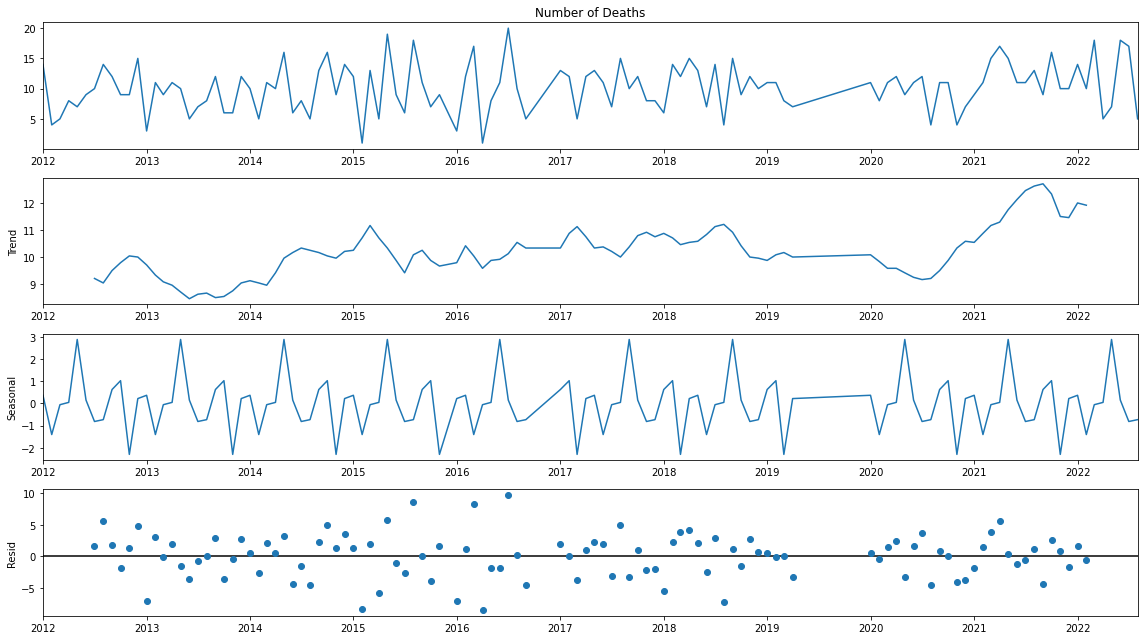

In [10]:
## Performing Time Series Analysis
## COVID and 9/11 related illness are exluded as they happened on a certain period of time only

## Exluding COVID and 9/11 related illness
df_exclude = df[(df["Cause of Death"] != " COVID19") & (df["Cause of Death"] != " 9/11 related illness")]

## Creating the timeseries dataset
df_ts = df_exclude
df_month = {"January": "01" , "February": "02", "March": "03", "April": "04", "May": "05", "June": "06", "July": "07",
            "August": "08", "September": "09", "October": "10", "November": "11", "December": "12"}
df_ts = df_ts.replace({"Month of Death": df_month})
df_ts["Month of Death"].unique()
df_ts["TS Date"] = df_ts["Year of Death"] + "-" + df_ts["Month of Death"]
df_ts = df_ts.groupby(["TS Date"]).count().reset_index()
df_ts = df_ts[["TS Date", "Name"]].rename(columns={"Name":"Number of Deaths"}).sort_values(by="TS Date", ascending= True)
df_ts.set_index('TS Date',inplace=True)
df_ts.index=pd.to_datetime(df_ts.index)

## Additive Time Series Decomposition
additive_decomposition=seasonal_decompose(df_ts['Number of Deaths'], model='additive', period=12)
fig = additive_decomposition.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()



In [11]:
## Grouping Deaths by State
df_map = df.groupby(['State of Death']).count().reset_index()
df_map = df_map[["State of Death", "Name"]].rename(columns={"Name":"Deaths"}).sort_values(by="Deaths", ascending=False)

## Dataset with State Name
df_states = pd.read_csv("/Users/maynardemmanuelmiranda/Desktop/Police Deaths in USA/States.csv")
df_states["State of Death"] = df_states["Code"]
df_states

## Merging the datasets
df_map = pd.merge(df_map, df_states, on="State of Death")

## Final Dataset
df_map = df_map[["State", "Code", "Deaths"]]


## Map Using Plotly
Code = df_map["Code"].values.tolist()
Deaths = df_map["Deaths"].values.tolist()
State = df_map["State"].values.tolist()

data = dict(type = "choropleth",
            locations = Code,
            locationmode = "USA-states",
            z = Deaths,
            colorscale= "Reds",
            colorbar = {"title": "colorbar"},
            text = State)


layout = dict(title = "Police Deaths in the United States from 2012 - 2022", 
              geo = {"scope": "usa"})


death_map = pg.Figure(data = [data] ,layout = layout)
death_map.update_layout(margin=dict(l=30, r=30, t=30, b=30))
po.iplot(death_map)
plt.show()



link to the datapane report: https://datapane.com/reports/E7ydl83/map-chart/